In [43]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from preprocessing import preprocess
import h5py
import urllib.request
import re
from maayanlab_bioinformatics.harmonization import ncbi_genes
from get_symbol import get_symbol
from prediction_pipeline import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso 
from tqdm import trange

# Loading gene expression data

In [2]:
f = pd.read_csv('GSE156063_swab_gene_counts.csv.gz')
f.index = f.iloc[:, 0] # Make ENSG genes as row indexing 
f = f.iloc[:, 1:] # Remove first index column 

In [3]:
f

,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1534,621,1903,2796,416,15,263,834,58,177,...,264,53,578,626,134,1,56,99,297,83
ENSG00000000419,153,123,221,344,112,20,45,116,26,46,...,83,97,110,132,57,15,19,1,33,19
ENSG00000000457,295,185,457,626,170,79,164,174,57,95,...,105,170,129,128,66,36,26,31,121,61
ENSG00000000460,75,108,292,367,49,31,37,57,44,35,...,21,117,44,68,27,9,1,0,24,60
ENSG00000000938,19,471,1843,284,38,539,495,9,1528,1409,...,139,87,49,133,62,4,3,1,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000287856,40,77,189,62,95,156,61,23,24,70,...,7,72,14,25,5,0,9,0,7,6
ENSG00000288258,0,21,2,41,34,0,5,7,5,0,...,8,3,0,3,0,0,0,2,2,5
ENSG00000288380,34,0,0,5,0,3,3,1,11,0,...,0,0,0,0,17,8,0,1,11,2


In [4]:
# Normalize data 
norm = preprocess(f)

In [5]:
# Convert Ensembl number index to gene symbol
norm = get_symbol(norm)
norm

,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
TSPAN6,9.750394,8.431520,8.536410,9.230869,8.419235,5.561493,8.145934,9.775714,6.667802,7.745806,...,8.180515,5.026008,9.526165,9.177776,7.941530,4.877658,7.910921,9.262038,10.033367,7.944507
DPM1,6.127114,6.002366,5.249229,5.956564,6.316461,5.903046,5.496793,6.622060,5.609731,5.970437,...,6.457110,5.953559,6.916508,6.714337,6.672384,7.162435,6.332690,5.013840,6.716536,5.725258
SCYL3,7.153231,6.591814,6.363691,6.867613,7.007707,7.547516,7.490316,7.278342,6.637774,6.962121,...,6.819049,6.785380,7.175186,6.659617,6.882470,8.217438,6.770866,7.830724,8.741190,7.488884
C1orf112,4.997992,5.799738,5.683124,6.048044,5.018780,6.428549,5.156712,5.526507,6.292580,5.570527,...,4.446830,6.219428,5.485222,5.672800,5.617461,6.589548,3.500152,0.000000,6.209080,7.462111
FGR,2.879951,8.019425,8.486833,5.658744,4.616182,9.779217,9.013250,2.671251,10.250164,9.878493,...,7.235374,5.791892,5.649619,6.727083,6.785820,5.786167,4.190450,5.014101,5.410709,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000287856,3.994869,5.268032,4.989002,3.355198,6.069830,8.355011,6.030361,4.080079,5.548841,6.573128,...,3.151128,5.504255,3.904021,4.138380,3.920471,4.872641,5.486766,5.008913,4.683105,4.091037
ENSG00000288258,0.381253,3.128959,0.741362,2.778832,4.494295,3.556651,2.403892,2.499549,3.556651,1.414968,...,3.304010,1.703540,1.119629,1.761382,2.820633,4.873239,3.494636,5.611814,3.624522,3.854520
ENSG00000288380,3.758763,0.257046,0.517748,0.877175,1.011474,4.267958,1.980540,1.130407,4.523328,1.416092,...,1.469524,0.989427,1.119629,0.900702,5.093880,6.588714,3.495341,5.365951,5.207784,2.973531
TMX2-CTNND1,5.747578,4.250350,5.048791,5.911258,4.322945,7.930172,4.013606,5.675303,5.923891,3.251837,...,4.621659,3.555366,3.804682,4.604726,7.120856,4.873239,3.495786,5.009396,2.869194,5.103178


# Principal component analysis for pathway representations

Convert gene x sample --> pathway x sample by getting a PCA representation for each gene x sample matrix with the genes representing a pathway.

In [6]:
libraries = ['GO_Biological_Process_2018', 'GO_Molecular_Function_2018', 'GO_Cellular_Component_2018']

In [8]:
pathway_by_sample = h5py.File("new_path_by_sample.h5", "w")

In [45]:
list_df = []
list_pathways = []
norm_genes = set(norm.index)
for lib in libraries: 
    pathway_to_genes, gene_set = gene_set_dictionaries(lib)
    for i in trange(len(pathway_to_genes)): 
        pathway = list(pathway_to_genes.keys())[i]
        genes = set(pathway_to_genes[pathway])
        if genes.issubset(norm_genes):
            pca = PCA(n_components=1)
            values = pca.fit_transform(norm.loc[genes].T)
            list_df.append( pd.DataFrame(values) )
            list_pathways.append(pathway)

100%|██████████| 446/446 [00:00<00:00, 1582.51it/s]


In [51]:
path_by_sample = pd.concat(list_df, axis=1).T
path_by_sample.index = list_pathways
path_by_sample.columns = norm.columns

In [54]:
path_by_sample

,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
positive regulation of posttranscriptional gene silencing (GO:0060148),-0.712626,-0.518708,-0.079418,-0.927214,-1.268372,1.976426,2.874613,-0.737923,2.279942,2.592232,...,-0.235965,0.999350,-0.797920,-0.127519,-1.143891,-0.063321,0.549553,-1.995243,-1.473321,-1.722733
protein insertion into mitochondrial membrane (GO:0051204),0.163754,-0.572385,1.434540,0.863279,1.322518,-0.913623,-0.375769,-0.375029,-2.699498,-2.067313,...,0.082166,-1.597091,1.102374,0.758424,-0.409101,-1.606694,0.897587,-2.446243,-0.367811,-1.088102
regulation of mitotic spindle assembly (GO:1901673),-1.276165,1.523933,-1.830973,-1.750910,-0.105619,-0.233917,0.201862,-0.894238,4.212487,-0.934902,...,-0.000456,1.276110,-0.868499,-0.060207,-0.984800,0.820813,1.100362,0.794172,-0.170326,3.601002
vacuolar acidification (GO:0007035),-1.698537,1.610197,2.840188,-0.411238,-1.712489,1.341146,2.716852,-1.828799,5.091329,5.930825,...,-0.686707,-0.471713,-1.436766,-0.220538,-2.178070,-1.876959,-6.819548,-4.056881,-1.923268,-1.326410
regulation of protein localization to early endosome (GO:1902965),-0.883854,-0.164574,0.451562,-0.686204,0.305173,2.007866,1.510654,-1.099112,1.951116,2.877247,...,-0.306420,1.855630,-0.773166,0.313168,-0.633146,-0.028489,-0.984281,-1.637769,-0.870504,-2.976364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"preribosome, small subunit precursor (GO:0030688)",-0.659570,0.820031,0.759117,-0.677737,-2.311741,-2.399453,0.366174,0.667423,2.478215,3.663547,...,-0.743643,-1.913788,-0.233485,-0.260990,-2.694742,-2.467003,-2.020607,-0.727905,-0.999856,0.754428
U7 snRNP (GO:0005683),-0.559555,-1.922056,-0.957433,-0.520759,0.759790,1.310580,-0.238245,-0.246861,2.334684,1.264565,...,1.342691,2.172940,0.035052,-0.038954,1.839840,0.468683,2.055398,-1.570803,1.291934,-1.403463
Set1C/COMPASS complex (GO:0048188),-0.716788,-0.662275,-1.238076,0.720791,0.511669,4.100662,2.240044,-0.612811,2.274749,1.500636,...,-1.779196,2.630920,-1.704090,-1.628779,-2.242640,2.083200,-1.358195,-0.856198,-0.939729,0.573044
clathrin vesicle coat (GO:0030125),0.094201,-0.929251,0.007277,0.412140,0.789413,0.374966,-0.080190,0.082162,0.910695,0.970266,...,-0.016797,-0.036131,-0.153230,-0.274970,-0.145192,0.104475,0.322825,-0.382703,0.429088,1.374923


In [57]:
pathway_by_sample.create_dataset("path_by_sample", data=path_by_sample)
pathway_list = (pd.DataFrame(path_by_sample.index)).values.astype("S").tolist()
sample_list = (pd.DataFrame(path_by_sample.columns)).values.astype("S").tolist()
pathway_by_sample.create_dataset("pathways", data=pathway_list)
pathway_by_sample.create_dataset("samples", data=sample_list)
pathway_by_sample.close()

<HDF5 dataset "samples": shape (234, 1), type "|S12">

# Ground truth data

In [59]:
gr_truth = pd.read_csv("GSE156063_series_matrix.txt", sep='\t')
gr_truth

,!Sample_title,RR057e_00202_N05_S78,RR057e_00080_H20_S312,RR057e_00287_L09_S140,RR057e_00753_G10_S151,RR057e_00751_C10_S147,RR057e_00520_I04_S57,RR057e_00505_K04_S59,RR057i_00083_K09_S139,RR057e_00764_F16_S246,...,RR057i_00136_J07_S106,RR057i_00137_L07_S108,RR057i_00156_N13_S206,RR057i_00158_F15_S230,RR057e_00719_H04_S56,RR057e_00721_L04_S60,RR057e_00731_H08_S120,RR057e_00728_N06_S94,RR057i_00067_C05_S67,RR057i_00116_E21_S325
0,!Sample_geo_accession,GSM4721578,GSM4721579,GSM4721580,GSM4721581,GSM4721582,GSM4721583,GSM4721584,GSM4721585,GSM4721586,...,GSM4721802,GSM4721803,GSM4721804,GSM4721805,GSM4721806,GSM4721807,GSM4721808,GSM4721809,GSM4721810,GSM4721811
1,!Sample_status,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,...,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020,Public on Aug 12 2020
2,!Sample_submission_date,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,...,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020,Aug 11 2020
3,!Sample_last_update_date,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,...,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020,Aug 12 2020
4,!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
5,!Sample_channel_count,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,!Sample_source_name_ch1,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,...,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab,NP/OP swab
7,!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
8,!Sample_characteristics_ch1,gender: F,gender: M,gender: F,gender: F,gender: F,gender: F,gender: M,gender: F,gender: F,...,gender: M,gender: F,gender: M,gender: F,gender: M,gender: M,gender: F,gender: F,gender: F,gender: F
9,!Sample_characteristics_ch1,age: 62,age: 81,age: 76,age: 36,age: 58,age: 79,age: 89,age: 63,age: 71,...,age: 44,age: 55,age: 31,age: 54,age: 40,age: 27,age: 63,age: 40,age: 44,age: 54


In [60]:
gr_truth = gr_truth.iloc[10, 1:]
idx = [ "_".join(i.split("_")[:2]) for i in gr_truth.index ]
gr_truth.index = idx
gr_truth

RR057e_00202    sars-cov-2 rpm: NEG
RR057e_00080    sars-cov-2 rpm: NEG
RR057e_00287    sars-cov-2 rpm: NEG
RR057e_00753    sars-cov-2 rpm: POS
RR057e_00751    sars-cov-2 rpm: POS
                       ...         
RR057e_00721    sars-cov-2 rpm: POS
RR057e_00731    sars-cov-2 rpm: POS
RR057e_00728    sars-cov-2 rpm: POS
RR057i_00067    sars-cov-2 rpm: POS
RR057i_00116    sars-cov-2 rpm: NEG
Name: 10, Length: 234, dtype: object

In [61]:
gr_truth = pd.DataFrame(gr_truth).loc[norm.columns]
test = [ 1 if res[-3:] == 'POS' else 0 for res in gr_truth.iloc[:, 0] ]
gr_truth.iloc[:, 0] = test
gr_truth.columns = ["Truth"]
gr_truth

,Truth
RR057e_00202,0
RR057e_00080,0
RR057e_00287,0
RR057e_00753,1
RR057e_00751,1
...,...
RR057e_00721,1
RR057e_00731,1
RR057e_00728,1
RR057i_00067,1


# Lasso model

In [83]:
pathway_by_sample = h5py.File("new_path_by_sample.h5", "r+")
def h5py_to_list(lst):
    return [ str(i)[3:-2] for i in lst ]

In [66]:
key_matrix = pathway_by_sample['path_by_sample']
key_pathways = h5py_to_list(pathway_by_sample['pathways'])
key_samples = h5py_to_list(pathway_by_sample['samples'])
key_df = pd.DataFrame(key_matrix, index=key_pathways, columns=key_samples)
display(key_df)

,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
positive regulation of posttranscriptional gene silencing (GO:0060148),-0.712626,-0.518708,-0.079418,-0.927214,-1.268372,1.976426,2.874613,-0.737923,2.279942,2.592232,...,-0.235965,0.999350,-0.797920,-0.127519,-1.143891,-0.063321,0.549553,-1.995243,-1.473321,-1.722733
protein insertion into mitochondrial membrane (GO:0051204),0.163754,-0.572385,1.434540,0.863279,1.322518,-0.913623,-0.375769,-0.375029,-2.699498,-2.067313,...,0.082166,-1.597091,1.102374,0.758424,-0.409101,-1.606694,0.897587,-2.446243,-0.367811,-1.088102
regulation of mitotic spindle assembly (GO:1901673),-1.276165,1.523933,-1.830973,-1.750910,-0.105619,-0.233917,0.201862,-0.894238,4.212487,-0.934902,...,-0.000456,1.276110,-0.868499,-0.060207,-0.984800,0.820813,1.100362,0.794172,-0.170326,3.601002
vacuolar acidification (GO:0007035),-1.698537,1.610197,2.840188,-0.411238,-1.712489,1.341146,2.716852,-1.828799,5.091329,5.930825,...,-0.686707,-0.471713,-1.436766,-0.220538,-2.178070,-1.876959,-6.819548,-4.056881,-1.923268,-1.326410
regulation of protein localization to early endosome (GO:1902965),-0.883854,-0.164574,0.451562,-0.686204,0.305173,2.007866,1.510654,-1.099112,1.951116,2.877247,...,-0.306420,1.855630,-0.773166,0.313168,-0.633146,-0.028489,-0.984281,-1.637769,-0.870504,-2.976364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"preribosome, small subunit precursor (GO:0030688)",-0.659570,0.820031,0.759117,-0.677737,-2.311741,-2.399453,0.366174,0.667423,2.478215,3.663547,...,-0.743643,-1.913788,-0.233485,-0.260990,-2.694742,-2.467003,-2.020607,-0.727905,-0.999856,0.754428
U7 snRNP (GO:0005683),-0.559555,-1.922056,-0.957433,-0.520759,0.759790,1.310580,-0.238245,-0.246861,2.334684,1.264565,...,1.342691,2.172940,0.035052,-0.038954,1.839840,0.468683,2.055398,-1.570803,1.291934,-1.403463
Set1C/COMPASS complex (GO:0048188),-0.716788,-0.662275,-1.238076,0.720791,0.511669,4.100662,2.240044,-0.612811,2.274749,1.500636,...,-1.779196,2.630920,-1.704090,-1.628779,-2.242640,2.083200,-1.358195,-0.856198,-0.939729,0.573044
clathrin vesicle coat (GO:0030125),0.094201,-0.929251,0.007277,0.412140,0.789413,0.374966,-0.080190,0.082162,0.910695,0.970266,...,-0.016797,-0.036131,-0.153230,-0.274970,-0.145192,0.104475,0.322825,-0.382703,0.429088,1.374923


## Lasso model

### Nested cross-validation to optimize lasso model

In [72]:
from numpy import mean, std
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [68]:
X, y = key_df.T, gr_truth.values.ravel()

1.0
0.9785714285714285
0.8857142857142857
0.9747899159663865
0.8384615384615385
0.9846153846153847
0.8492063492063492
0.8650793650793651
0.9375
0.8809523809523809
AUC: 0.919 (0.059)


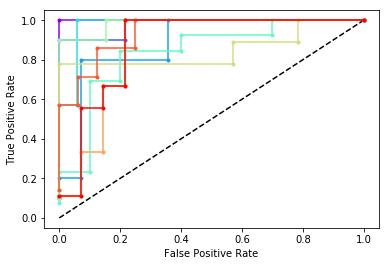

In [75]:
# generate no skill prediction
ns_probs = [0 for n in y]
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='black')

# configure the cross-validation procedure 
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

# enumerate splits 
outer_results = []
summary = []
color=iter(cm.rainbow(np.linspace(0,1,10)))
for train_idx, test_idx in cv_outer.split(X):
    # split data 
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    # configure the cross-validation procedure 
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model 
    lassocv = LassoCV(alphas=None, cv=cv_inner, max_iter=100000)
    result = lassocv.fit(X_train, y_train)
    # evaluate model on the holdout dataset 
    yhat = result.predict(X_test)
    # evaluate model
    fpr, tpr, _ = roc_curve(y_test, yhat)
    auc_ = metrics.auc(fpr, tpr)
    outer_results.append(auc_)
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.', color=next(color))
    # report progress
    print(auc_)
    # add parameters to summary 
    summary.append(result.coef_)
# summarize estimated model performance
print('AUC: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show()

In [76]:
# get summary table 
sum_df = pd.DataFrame(summary, columns=X.columns)

In [77]:
summary_cols = (pd.DataFrame(X.columns)).values.astype("S").tolist()
pathway_by_sample.create_dataset("summaries", data=sum_df)
pathway_by_sample.create_dataset("summaries_columns", data=summary_cols)

<HDF5 dataset "summaries_columns": shape (1443, 1), type "|S160">

In [78]:
pathway_by_sample.close()

In [79]:
sum_df

,positive regulation of posttranscriptional gene silencing (GO:0060148),protein insertion into mitochondrial membrane (GO:0051204),regulation of mitotic spindle assembly (GO:1901673),vacuolar acidification (GO:0007035),regulation of protein localization to early endosome (GO:1902965),negative regulation of viral-induced cytoplasmic pattern recognition receptor signaling pathway (GO:0039532),negative regulation of membrane potential (GO:0045837),glucan catabolic process (GO:0009251),membrane raft polarization (GO:0001766),positive regulation of peptidyl-lysine acetylation (GO:2000758),...,cytoplasmic exosome (RNase complex) (GO:0000177),Cul5-RING ubiquitin ligase complex (GO:0031466),microtubule plus-end (GO:0035371),endocytic patch (GO:0061645),"DNA-directed RNA polymerase II, core complex (GO:0005665)","preribosome, small subunit precursor (GO:0030688)",U7 snRNP (GO:0005683),Set1C/COMPASS complex (GO:0048188),clathrin vesicle coat (GO:0030125),"signal recognition particle, endoplasmic reticulum targeting (GO:0005786)"
0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
1,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,...,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
3,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,...,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
4,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
5,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
6,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
7,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
8,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
9,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0


In [80]:
new_sum_df = sum_df.loc[:, (sum_df != 0).any(axis=0)]

In [81]:
new_sum_df

,protein localization to microtubule organizing center (GO:1905508),protein localization to non-motile cilium (GO:0097499),regulation of phospholipase C activity (GO:1900274),bleb assembly (GO:0032060),positive regulation of calcineurin-NFAT signaling cascade (GO:0070886),T-helper 17 cell differentiation (GO:0072539),regulation of amyloid precursor protein biosynthetic process (GO:0042984),regulation of Arp2/3 complex-mediated actin nucleation (GO:0034315),negative regulation of pri-miRNA transcription from RNA polymerase II promoter (GO:1902894),response to interferon-alpha (GO:0035455),...,phosphatidylinositol 3-kinase regulatory subunit binding (GO:0036312),sphingosine N-acyltransferase activity (GO:0050291),annealing helicase activity (GO:0036310),MLL3/4 complex (GO:0044666),endoplasmic reticulum subcompartment (GO:0098827),chromatin silencing complex (GO:0005677),manchette (GO:0002177),Gemini of coiled bodies (GO:0097504),paranode region of axon (GO:0033270),Cul2-RING ubiquitin ligase complex (GO:0031462)
0,-0.000000,-0.010695,-0.000000,-0.000000,-0.000000,0.000000,0.000906,0.002273,-0.005291,-0.055441,...,-0.011652,0.000000,-0.013764,-0.001600,0.00000,0.000000,0.014274,-0.000000,0.000000,-0.004843
1,-0.000229,-0.008315,-0.000000,-0.000000,-0.004489,0.000000,0.005287,0.000000,-0.000000,-0.061203,...,-0.000000,0.000000,-0.015423,-0.000000,0.00358,0.005621,0.015380,-0.006628,0.000000,-0.000000
2,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.003316,0.000000,-0.008509,-0.061334,...,-0.000000,0.002977,-0.013107,-0.000077,0.00000,0.000000,0.026812,-0.009460,0.000000,-0.000000
3,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.001021,0.000000,-0.000000,-0.058838,...,-0.000000,0.000000,-0.000000,-0.000000,0.00000,0.000000,0.008709,-0.000000,0.000729,-0.000000
4,-0.000000,-0.006331,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.045264,...,-0.000000,0.000000,-0.000000,-0.000000,0.00000,0.000000,0.006249,-0.000000,0.000000,-0.000000
5,-0.000000,-0.010293,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.003632,-0.000000,-0.076838,...,-0.010601,0.000000,-0.001680,0.000000,0.00000,0.008419,0.015966,-0.000000,0.000000,-0.019440
6,-0.000000,-0.000000,-0.000000,-0.001221,-0.000000,0.000000,0.001382,0.000000,-0.000000,-0.044318,...,-0.004379,0.000000,-0.000000,0.000000,0.00000,0.000000,0.015412,-0.000000,0.000000,-0.000000
7,-0.000000,-0.009626,-0.008318,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.062167,...,-0.013332,0.000000,-0.000000,-0.000000,0.00000,0.000000,0.014560,-0.000000,0.000000,-0.000000
8,-0.000000,-0.004709,-0.008243,-0.000000,-0.000000,0.000000,0.001146,0.000000,-0.000000,-0.046508,...,-0.004855,0.000000,-0.000000,0.000000,0.00000,0.000000,0.019325,-0.000000,0.000000,-0.000000
9,-0.000000,-0.000590,-0.005024,-0.000000,-0.004345,0.002658,0.010891,0.000000,-0.004553,-0.050091,...,-0.000000,0.000000,-0.013413,-0.000000,0.00000,0.000000,0.024451,-0.000000,0.000000,-0.010627


## Get pathway lambda data

In [84]:
list(pathway_by_sample.keys())

['path_by_sample', 'pathways', 'samples', 'summaries', 'summaries_columns']

In [85]:
summaries_columns = [str(pathway)[3:-2] for pathway in pathway_by_sample['summaries_columns']]

In [86]:
summaries = pd.DataFrame(pathway_by_sample['summaries'], columns=summaries_columns)

In [87]:
summaries

,positive regulation of posttranscriptional gene silencing (GO:0060148),protein insertion into mitochondrial membrane (GO:0051204),regulation of mitotic spindle assembly (GO:1901673),vacuolar acidification (GO:0007035),regulation of protein localization to early endosome (GO:1902965),negative regulation of viral-induced cytoplasmic pattern recognition receptor signaling pathway (GO:0039532),negative regulation of membrane potential (GO:0045837),glucan catabolic process (GO:0009251),membrane raft polarization (GO:0001766),positive regulation of peptidyl-lysine acetylation (GO:2000758),...,cytoplasmic exosome (RNase complex) (GO:0000177),Cul5-RING ubiquitin ligase complex (GO:0031466),microtubule plus-end (GO:0035371),endocytic patch (GO:0061645),"DNA-directed RNA polymerase II, core complex (GO:0005665)","preribosome, small subunit precursor (GO:0030688)",U7 snRNP (GO:0005683),Set1C/COMPASS complex (GO:0048188),clathrin vesicle coat (GO:0030125),"signal recognition particle, endoplasmic reticulum targeting (GO:0005786)"
0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
1,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,...,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
3,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,...,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
4,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
5,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
6,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
7,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
8,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
9,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0


In [88]:
new_df = summaries.loc[:, (summaries != 0).any(axis=0)]

In [89]:
new_df

,protein localization to microtubule organizing center (GO:1905508),protein localization to non-motile cilium (GO:0097499),regulation of phospholipase C activity (GO:1900274),bleb assembly (GO:0032060),positive regulation of calcineurin-NFAT signaling cascade (GO:0070886),T-helper 17 cell differentiation (GO:0072539),regulation of amyloid precursor protein biosynthetic process (GO:0042984),regulation of Arp2/3 complex-mediated actin nucleation (GO:0034315),negative regulation of pri-miRNA transcription from RNA polymerase II promoter (GO:1902894),response to interferon-alpha (GO:0035455),...,phosphatidylinositol 3-kinase regulatory subunit binding (GO:0036312),sphingosine N-acyltransferase activity (GO:0050291),annealing helicase activity (GO:0036310),MLL3/4 complex (GO:0044666),endoplasmic reticulum subcompartment (GO:0098827),chromatin silencing complex (GO:0005677),manchette (GO:0002177),Gemini of coiled bodies (GO:0097504),paranode region of axon (GO:0033270),Cul2-RING ubiquitin ligase complex (GO:0031462)
0,-0.000000,-0.010695,-0.000000,-0.000000,-0.000000,0.000000,0.000906,0.002273,-0.005291,-0.055441,...,-0.011652,0.000000,-0.013764,-0.001600,0.00000,0.000000,0.014274,-0.000000,0.000000,-0.004843
1,-0.000229,-0.008315,-0.000000,-0.000000,-0.004489,0.000000,0.005287,0.000000,-0.000000,-0.061203,...,-0.000000,0.000000,-0.015423,-0.000000,0.00358,0.005621,0.015380,-0.006628,0.000000,-0.000000
2,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.003316,0.000000,-0.008509,-0.061334,...,-0.000000,0.002977,-0.013107,-0.000077,0.00000,0.000000,0.026812,-0.009460,0.000000,-0.000000
3,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.001021,0.000000,-0.000000,-0.058838,...,-0.000000,0.000000,-0.000000,-0.000000,0.00000,0.000000,0.008709,-0.000000,0.000729,-0.000000
4,-0.000000,-0.006331,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.045264,...,-0.000000,0.000000,-0.000000,-0.000000,0.00000,0.000000,0.006249,-0.000000,0.000000,-0.000000
5,-0.000000,-0.010293,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.003632,-0.000000,-0.076838,...,-0.010601,0.000000,-0.001680,0.000000,0.00000,0.008419,0.015966,-0.000000,0.000000,-0.019440
6,-0.000000,-0.000000,-0.000000,-0.001221,-0.000000,0.000000,0.001382,0.000000,-0.000000,-0.044318,...,-0.004379,0.000000,-0.000000,0.000000,0.00000,0.000000,0.015412,-0.000000,0.000000,-0.000000
7,-0.000000,-0.009626,-0.008318,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.062167,...,-0.013332,0.000000,-0.000000,-0.000000,0.00000,0.000000,0.014560,-0.000000,0.000000,-0.000000
8,-0.000000,-0.004709,-0.008243,-0.000000,-0.000000,0.000000,0.001146,0.000000,-0.000000,-0.046508,...,-0.004855,0.000000,-0.000000,0.000000,0.00000,0.000000,0.019325,-0.000000,0.000000,-0.000000
9,-0.000000,-0.000590,-0.005024,-0.000000,-0.004345,0.002658,0.010891,0.000000,-0.004553,-0.050091,...,-0.000000,0.000000,-0.013413,-0.000000,0.00000,0.000000,0.024451,-0.000000,0.000000,-0.010627


In [90]:
lambda_counts = pd.DataFrame(new_df.astype(bool).sum(axis=0), columns=["Count"]).sort_values(by='Count', ascending=True)

In [91]:
lambda_counts

,Count
protein localization to microtubule organizing center (GO:1905508),1
positive regulation of mitochondrial membrane potential (GO:0010918),1
retinal ganglion cell axon guidance (GO:0031290),1
lysine catabolic process (GO:0006554),1
mature B cell differentiation involved in immune response (GO:0002313),1
...,...
xenobiotic catabolic process (GO:0042178),10
negative regulation of viral transcription (GO:0032897),10
activin binding (GO:0048185),10
manchette (GO:0002177),10


## Bar Plot

In [92]:
lambdas = lambda_counts.iloc[-30:]
lambdas.loc[:, 'Count'] /= 10
lambdas['labels'] = lambdas.index

/hpc/home/cy125/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


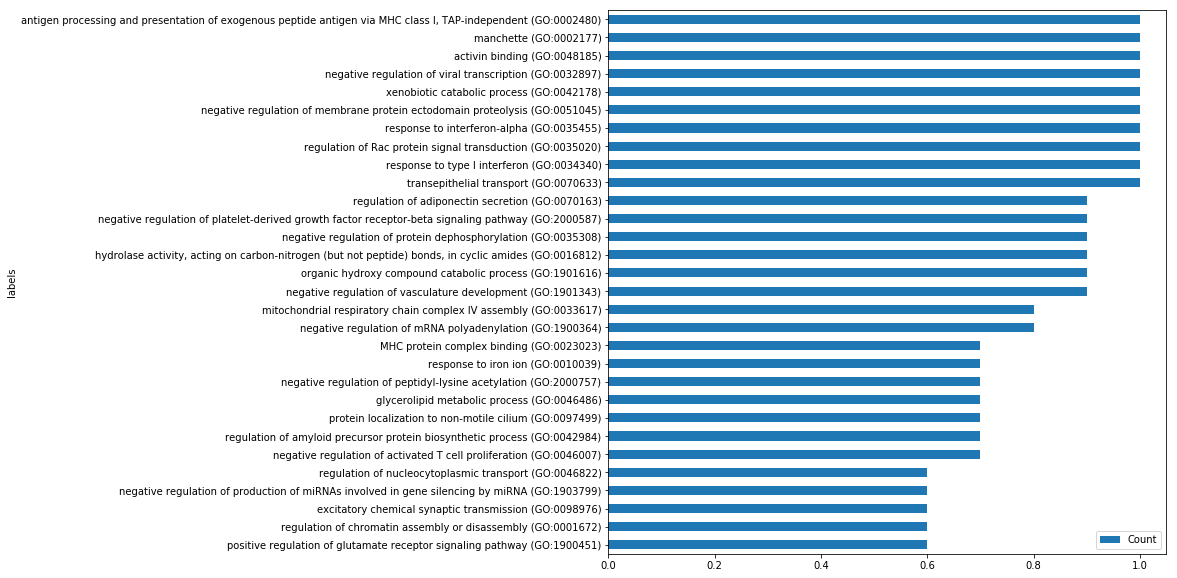

In [93]:
ax = lambdas.plot.barh(x='labels', y='Count', figsize=(10,10))

In [94]:
usage_dict = {"100% Usage": [0], "50% Usage": [0], "25% Usage": [0], "Total": [len(lambda_counts)]}
for val in lambda_counts.values:
    if val[0] == 10: usage_dict["100% Usage"][0] += 1
    elif val[0] > 5: usage_dict["50% Usage"][0] += 1
    elif val[0] > 2.5: usage_dict["25% Usage"][0] += 1

In [95]:
usage_df = pd.DataFrame(usage_dict, index=[''])
usage_df

,100% Usage,50% Usage,25% Usage,Total
,10,21,27,115


## Box Plot

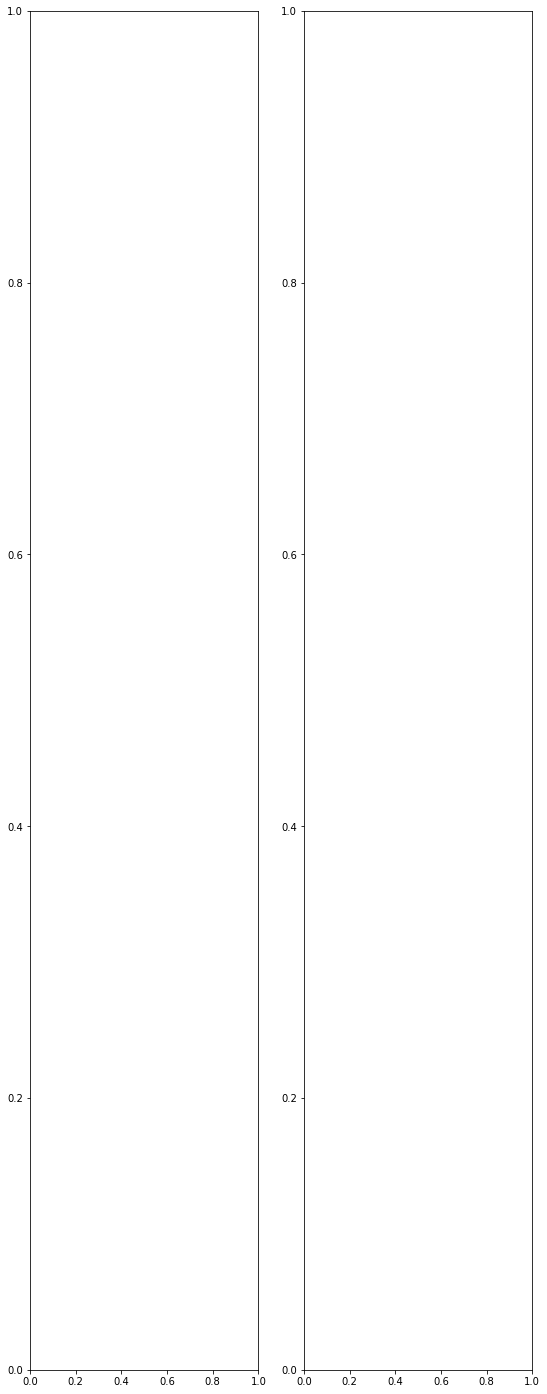

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 25))

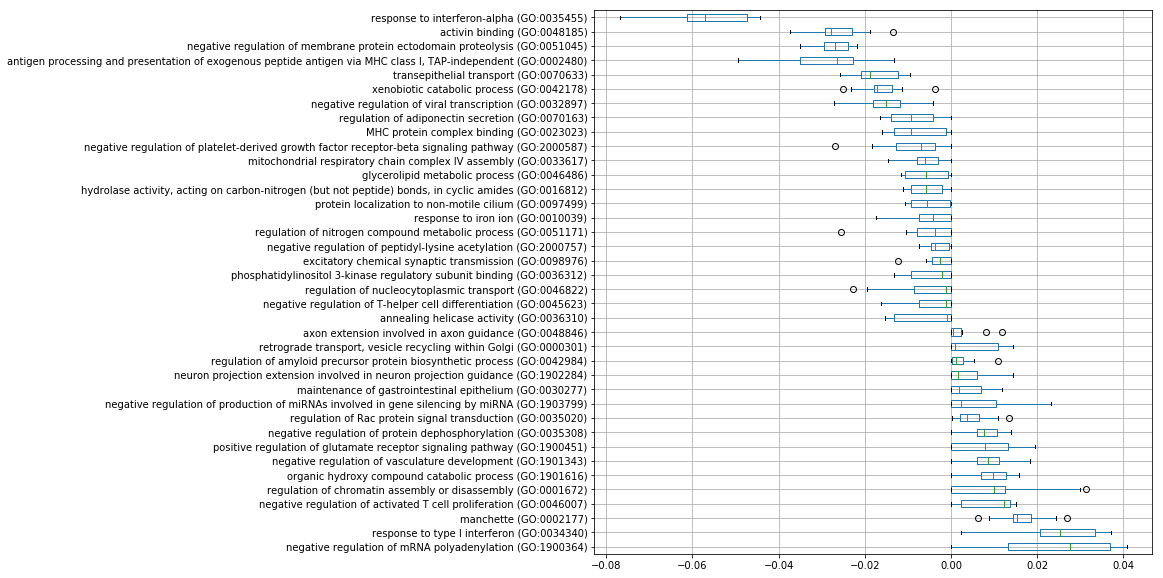

In [97]:
meds = summaries.median()
meds.sort_values(ascending=False, inplace=True)
meds = meds[meds != 0]
df2 = summaries[meds.index]
df2.boxplot(vert=False, rot=0, figsize=(10,10))